## Chunking to Network Graph

This notebook walks through an example that builds a co-occurrence matrix for two strings taken from two speeches and turns them into a network graph based on a cosine similarity. 

In [59]:
import nltk
from nltk import RegexpParser
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import spacy
import pandas as pd

In [60]:
string = 'Already, we have done more to advance the cause of health care reform in the last thirty days than we have in the last decade.  When it was days old, this Congress passed a law to provide and protect health insurance for eleven million American children whose parents work full-time.  Our recovery plan will invest in electronic health records and new technology that will reduce errors, bring down costs, ensure privacy, and save lives.  It will launch a new effort to conquer a disease that has touched the life of nearly every American by seeking a cure for cancer in our time.  And it makes the largest investment ever in preventive care, because that is one of the best ways to keep our people healthy and our costs under control.'
string2 = 'A future of hope and opportunity requires that all our citizens have affordable and available health care. When it comes to health care, government has an obligation to care for the elderly, the disabled, and poor children, and we will meet those responsibilities. For all other Americans, private health care insurance is the best way to meet their needs. But many Americans cannot afford a health insurance policy.'

Putting the strings into a list for some experiments with TF-IDF

In [61]:
strings = list((string, string2))

Some brief cleaning up using tokens and part of speech tagging

In [62]:
sentences = nltk.sent_tokenize(string)
sentences = [nltk.word_tokenize(sent) for sent in sentences]
sentences = [nltk.pos_tag(sent) for sent in sentences]

In [63]:
sentences

[[('Already', 'RB'),
  (',', ','),
  ('we', 'PRP'),
  ('have', 'VBP'),
  ('done', 'VBN'),
  ('more', 'JJR'),
  ('to', 'TO'),
  ('advance', 'VB'),
  ('the', 'DT'),
  ('cause', 'NN'),
  ('of', 'IN'),
  ('health', 'NN'),
  ('care', 'NN'),
  ('reform', 'NN'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('last', 'JJ'),
  ('thirty', 'NN'),
  ('days', 'NNS'),
  ('than', 'IN'),
  ('we', 'PRP'),
  ('have', 'VBP'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('last', 'JJ'),
  ('decade', 'NN'),
  ('.', '.')],
 [('When', 'WRB'),
  ('it', 'PRP'),
  ('was', 'VBD'),
  ('days', 'NNS'),
  ('old', 'JJ'),
  (',', ','),
  ('this', 'DT'),
  ('Congress', 'NNP'),
  ('passed', 'VBD'),
  ('a', 'DT'),
  ('law', 'NN'),
  ('to', 'TO'),
  ('provide', 'VB'),
  ('and', 'CC'),
  ('protect', 'VB'),
  ('health', 'NN'),
  ('insurance', 'NN'),
  ('for', 'IN'),
  ('eleven', 'JJ'),
  ('million', 'CD'),
  ('American', 'JJ'),
  ('children', 'NNS'),
  ('whose', 'WP$'),
  ('parents', 'NNS'),
  ('work', 'VBP'),
  ('full-time', 'NN'),
  ('.', '.'

We're chunking based on the following Regex parser, which takes an optional determinant, any number of adjectives, and any number of nouns in sequence as a noun phrase

In [64]:
grammar = "NP: {<DT>?<JJ.*><NN.*>+}"

In [65]:
cp = nltk.RegexpParser(grammar)
for i in sentences:
    result = cp.parse(i)
    print(result)

(S
  Already/RB
  ,/,
  we/PRP
  have/VBP
  done/VBN
  more/JJR
  to/TO
  advance/VB
  the/DT
  cause/NN
  of/IN
  health/NN
  care/NN
  reform/NN
  in/IN
  (NP the/DT last/JJ thirty/NN days/NNS)
  than/IN
  we/PRP
  have/VBP
  in/IN
  (NP the/DT last/JJ decade/NN)
  ./.)
(S
  When/WRB
  it/PRP
  was/VBD
  days/NNS
  old/JJ
  ,/,
  this/DT
  Congress/NNP
  passed/VBD
  a/DT
  law/NN
  to/TO
  provide/VB
  and/CC
  protect/VB
  health/NN
  insurance/NN
  for/IN
  eleven/JJ
  million/CD
  (NP American/JJ children/NNS)
  whose/WP$
  parents/NNS
  work/VBP
  full-time/NN
  ./.)
(S
  Our/PRP$
  recovery/NN
  plan/NN
  will/MD
  invest/VB
  in/IN
  (NP electronic/JJ health/NN records/NNS)
  and/CC
  (NP new/JJ technology/NN)
  that/WDT
  will/MD
  reduce/VB
  errors/NNS
  ,/,
  bring/VBG
  down/RP
  costs/NNS
  ,/,
  ensure/VB
  privacy/NN
  ,/,
  and/CC
  save/VB
  lives/NNS
  ./.)
(S
  It/PRP
  will/MD
  launch/VB
  (NP a/DT new/JJ effort/NN)
  to/TO
  conquer/VB
  a/DT
  disease/NN
  that

A separate approach is to use the spacy function for noun chunks which automates the process. I'll use that for the rest of the notebook

In [66]:
def spacy_fxn(strings):
    
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(strings)
    l = []
    for token in doc.noun_chunks:
        l.append(token)
    print(l)
    
    new_dict = {}
    for i in l:
        if str(i) in new_dict:
            new_dict[str(i)] += 1
        else:
            new_dict[str(i)] = 1
    return new_dict

In [67]:
dict1 = spacy_fxn(string)

[we, the cause, health care reform, the last thirty days, we, the last decade, it, this Congress, a law, health insurance, eleven million American children, whose parents, Our recovery plan, electronic health records, new technology, errors, costs, privacy, lives, It, a new effort, a disease, the life, nearly every American, a cure, cancer, our time, it, the largest investment, preventive care, the best ways, our people, our costs, control]


In [68]:
dict2 = spacy_fxn(string2)

[A future, hope, opportunity, all our citizens, affordable and available health care, it, health care, government, an obligation, poor children, we, those responsibilities, all other Americans, private health care insurance, the best way, their needs, many Americans, a health insurance policy]


In [70]:
dict1_df = pd.DataFrame(dict1, index =[0])

In [71]:
df_asint = dict1_df.astype(int)
coocc = df_asint.T.dot(df_asint)
coocc

,we,the cause,health care reform,the last thirty days,the last decade,it,this Congress,a law,health insurance,eleven million American children,...,nearly every American,a cure,cancer,our time,the largest investment,preventive care,the best ways,our people,our costs,control
we,4,2,2,2,2,4,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
the cause,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
health care reform,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
the last thirty days,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
the last decade,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
it,4,2,2,2,2,4,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
this Congress,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
a law,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
health insurance,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
eleven million American children,2,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [72]:
dict2_df = pd.DataFrame(dict2, index =[0])

In [73]:
df_asint1 = dict2_df.astype(int)
coocc1 = df_asint1.T.dot(df_asint1)
coocc1

,A future,hope,opportunity,all our citizens,affordable and available health care,it,health care,government,an obligation,poor children,we,those responsibilities,all other Americans,private health care insurance,the best way,their needs,many Americans,a health insurance policy
A future,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
hope,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
opportunity,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
all our citizens,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
affordable and available health care,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
it,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
health care,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
government,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
an obligation,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
poor children,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Here we're adding the two co-occurrence matrices. 

In [74]:
c = coocc1.add(coocc, fill_value = 0)
c = c.fillna(0)

In [75]:
c

,A future,It,Our recovery plan,a cure,a disease,a health insurance policy,a law,a new effort,affordable and available health care,all other Americans,...,the cause,the largest investment,the last decade,the last thirty days,the life,their needs,this Congress,those responsibilities,we,whose parents
A future,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
It,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0
Our recovery plan,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0
a cure,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0
a disease,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0
a health insurance policy,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
a law,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0
a new effort,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0
affordable and available health care,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
all other Americans,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


Taking a pairwise cosine similarity which we can use to determine how the rows relate to each other (we might need a different similiarity measure)

In [76]:
sim = pd.DataFrame(cosine_similarity(c))
sim.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,1.000000,0.152944,0.152944,0.152944,0.152944,1.000000,0.152944,0.152944,1.000000,1.000000,...,0.152944,0.152944,0.152944,0.152944,0.152944,1.000000,0.152944,1.000000,0.449346,0.152944
1,0.152944,1.000000,1.000000,1.000000,1.000000,0.152944,1.000000,1.000000,0.152944,0.152944,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.152944,1.000000,0.152944,0.951572,1.000000
2,0.152944,1.000000,1.000000,1.000000,1.000000,0.152944,1.000000,1.000000,0.152944,0.152944,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.152944,1.000000,0.152944,0.951572,1.000000
3,0.152944,1.000000,1.000000,1.000000,1.000000,0.152944,1.000000,1.000000,0.152944,0.152944,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.152944,1.000000,0.152944,0.951572,1.000000
4,0.152944,1.000000,1.000000,1.000000,1.000000,0.152944,1.000000,1.000000,0.152944,0.152944,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.152944,1.000000,0.152944,0.951572,1.000000


Using the similiarity matrix, we draw the network graph which gives us two distinct 'topics', in this case corresponding to each speech

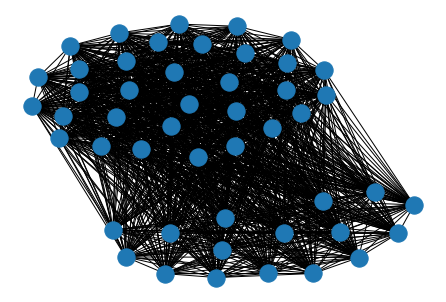

In [77]:
graph = nx.from_numpy_matrix(sim.values)
nx.draw(graph)
plt.show()

One last thing here, playing around with TF-IDF, which is a sklearn function that takes in a list of the strings (in this case strings). The question becomes how does this relate to the earlier attempts to count frequencies of noun phrases and how they co-occur with each other based on paragraphs

In [78]:
vectorizer = TfidfVectorizer()
response = vectorizer.fit_transform(strings)

In [79]:
vectorizer.get_feature_names()

['advance',
 'afford',
 'affordable',
 'all',
 'already',
 'american',
 'americans',
 'an',
 'and',
 'available',
 'because',
 'best',
 'bring',
 'but',
 'by',
 'cancer',
 'cannot',
 'care',
 'cause',
 'children',
 'citizens',
 'comes',
 'congress',
 'conquer',
 'control',
 'costs',
 'cure',
 'days',
 'decade',
 'disabled',
 'disease',
 'done',
 'down',
 'effort',
 'elderly',
 'electronic',
 'eleven',
 'ensure',
 'errors',
 'ever',
 'every',
 'for',
 'full',
 'future',
 'government',
 'has',
 'have',
 'health',
 'healthy',
 'hope',
 'in',
 'insurance',
 'invest',
 'investment',
 'is',
 'it',
 'keep',
 'largest',
 'last',
 'launch',
 'law',
 'life',
 'lives',
 'makes',
 'many',
 'meet',
 'million',
 'more',
 'nearly',
 'needs',
 'new',
 'obligation',
 'of',
 'old',
 'one',
 'opportunity',
 'other',
 'our',
 'parents',
 'passed',
 'people',
 'plan',
 'policy',
 'poor',
 'preventive',
 'privacy',
 'private',
 'protect',
 'provide',
 'records',
 'recovery',
 'reduce',
 'reform',
 'requires

In [81]:
z = pd.DataFrame(response.toarray())
z.head()

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,0.072169,0.000000,0.000000,0.000000,0.072169,0.144338,0.000000,0.000000,0.256744,0.000000,...,0.072169,0.072169,0.072169,0.000000,0.072169,0.102698,0.051349,0.072169,0.154046,0.072169
1,0.000000,0.110745,0.110745,0.221489,0.000000,0.000000,0.221489,0.110745,0.315183,0.110745,...,0.000000,0.000000,0.000000,0.110745,0.000000,0.078796,0.078796,0.000000,0.078796,0.000000
